# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов.

Цель проекта: построить модель, определяющую по фотографии приблизительный возраст человека.

Работать предстоит с датасетом фотографий людей с указанием возраста.

В ходе проекта планируется:

- Провести исследовательский анализ набора фотографий
- Подготовить данные к обучению
- Обучить нейронную сверточную сеть, достигнув качества метрики MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Загрузим датасет:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Разделим данные:

In [3]:
features, target = next(data_gen_flow)

Посмотрим на вывод данных и сопоставление их с возрастами:

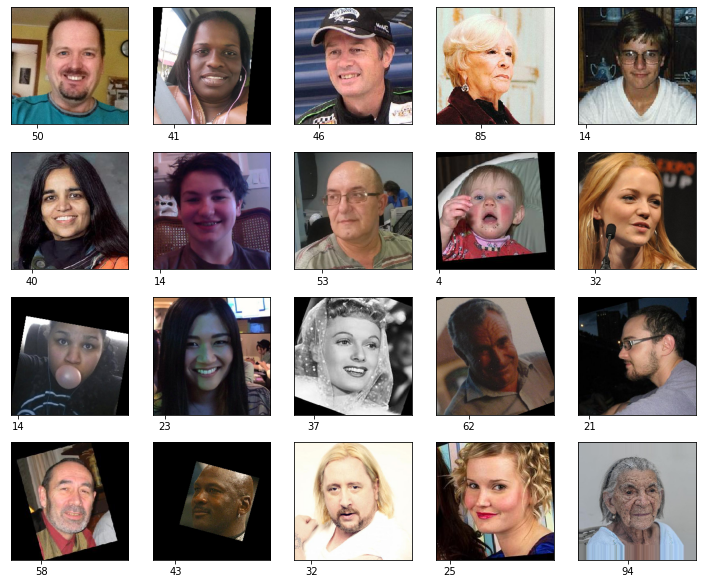

In [4]:
fig = plt.figure(figsize=(10,10)) 
for i in range(20):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([target[i]])
    plt.yticks([])
    plt.tight_layout()

Визуально картинки соответствуют указанным возрастам.

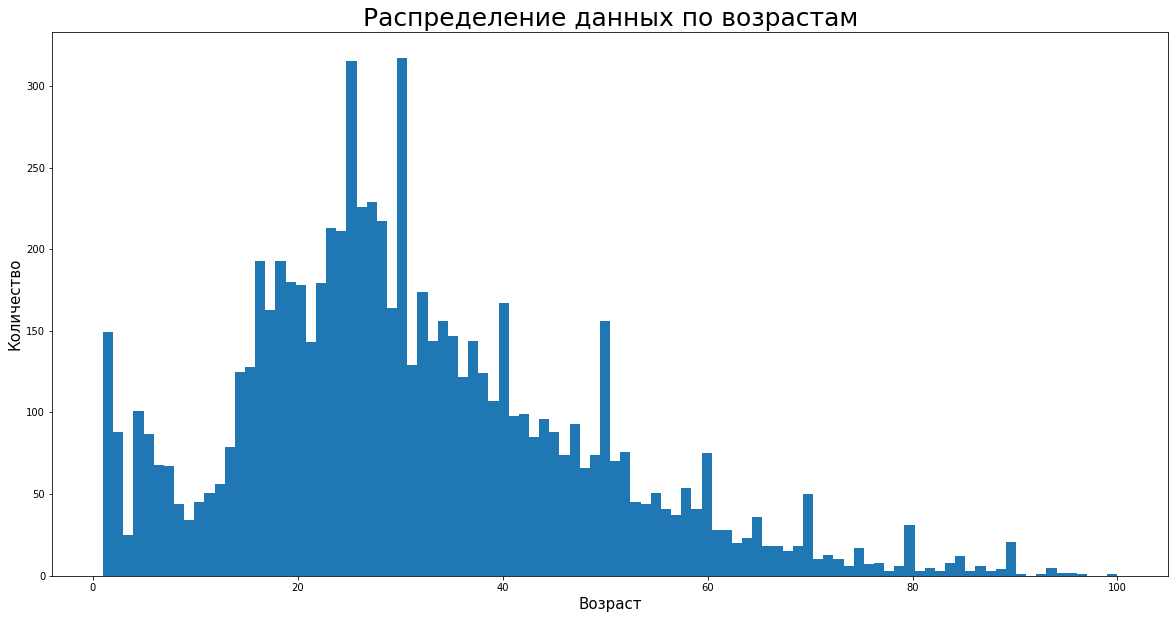

In [19]:
plt.figure(figsize=(20,10))
plt.hist(data_gen_flow.labels, bins=100)
plt.xlabel('Возраст', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Распределение данных по возрастам', fontsize=25);

In [31]:
print('Минимальный возраст:', labels['real_age'].min(), ', Максимальный возраст:', labels['real_age'].max())

Минимальный возраст: 1 , Максимальный возраст: 100


У нас есть шкала со всеми возрастами от 1-100 лет есть пропуски, есть некоторые выбросы. Минимальный возраст 1 год, максимальный 100 лет.

**Вывод:** Для нашей задачи данных достаточно, для улучшения качества модели можно добавить аугментацию с бликами или дефокусировкой, с поворотами по горизонтали и вертикали в наборе уже есть изображения.

## Обучение модели

Для обучения выбрана нейронная сеть ResNet50, заменен выходной слой под решение нашей задачи регрессии. Метрикой качества выбрана MAE.

```python

import pandas as pd

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50





def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        
    )
    
 
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        
    )
    
 
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 48s - loss: 238.9368 - mae: 11.0147 - val_loss: 433.9007 - val_mae: 15.7696
Epoch 2/10
178/178 - 39s - loss: 62.0459 - mae: 5.9083 - val_loss: 705.0007 - val_mae: 21.5748
Epoch 3/10
178/178 - 39s - loss: 31.1628 - mae: 4.3005 - val_loss: 341.8656 - val_mae: 13.7134
Epoch 4/10
178/178 - 39s - loss: 19.7960 - mae: 3.4023 - val_loss: 118.9601 - val_mae: 8.4107
Epoch 5/10
178/178 - 37s - loss: 15.6175 - mae: 3.0411 - val_loss: 86.8961 - val_mae: 7.0073
Epoch 6/10
178/178 - 37s - loss: 13.1026 - mae: 2.7709 - val_loss: 72.5433 - val_mae: 6.4472
Epoch 7/10
178/178 - 37s - loss: 10.1642 - mae: 2.4551 - val_loss: 66.9311 - val_mae: 6.2405
Epoch 8/10
178/178 - 39s - loss: 8.3457 - mae: 2.1787 - val_loss: 88.9442 - val_mae: 7.4556
Epoch 9/10
178/178 - 39s - loss: 7.6282 - mae: 2.0927 - val_loss: 64.4789 - val_mae: 6.1632
Epoch 10/10
178/178 - 40s - loss: 7.0583 - mae: 2.0002 - val_loss: 63.6852 - val_mae: 6.0484

60/60 - 10s - loss: 63.6852 - mae: 6.0484
Test MAE: 6.0484

```

На тестовой выборке достигнуто значение MAE=6. Как видно из обучения, с каждой эпохой уменьшается ошибка и улучшается метрика качества.

**Вывод:** Обучена модель с помощью нейросети ResNet50, средняя абсолютная ошибка 6 единиц.

## Анализ обученной модели

Перед нами стояла задача обучения регрессионной модели. На выходе мы ожидаем одно число - возраст покупателя, для этого нам необходим только один нейрон. В качестве функции потерь была выбрана функция среднеквадратической ошибки, метрикой качества выбрана средняя абсолютная ошибка.

За основу взята архитектура сети с 50 слоями ResNet50. Инициализация весов сделана с ImageNet предобученными весами. Заменен выходной слой на слой с одним нейроном. Данные разбиты на батчи по 32 объекта, размером 224х224 пикселя. Подключили оптимизатор Adam с шагом обучения lr=0.0001. После 10 эпох модель показала удовлетворительное качество метрики. С каждой эпохой мы видим, что равномерно уменьшается ошибка и улучшается метрика качества на тренировочной выборке. Достигнута допустимая метрика MAE=6.

**Итоговые выводы:**

Цель проекта заключалась в обучении модели для системы компьютерного зрения, предсказывающую возраст покупателя по фотографии.

В ходе проекта:

- проведен исследовательский анализ набора фотографий
- подготовлены данные к обучению, разделены данные на батчи, определены тренировочная и тестовые выборки.
- обучена нейронная сверточная сеть ResNet50, достигнуто необходимое качество метрики MAE, на тестовой выборке равной 6 единицам.

Обученная модель способна определить возраст покупателя по фотографии с ошибкой в 6 лет.